# Model Definition and Evaluation
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)
5. [Evaluation Metrics](#evaluation-metrics)
6. [Comparative Analysis](#comparative-analysis)


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
# set logging level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow import keras

# Params
SEED = 123
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


## Model Selection

I pondered the use of different established models for Image Classification, because I was shure that I could not create a better Neural Net from scratch. I read about different NNs and landed first on ResNet50 because of an article about monochromatic image classification (I can no longer find it, and did not save it ). I changed it to the ResNet 152V2 because of the better performance of the second version of the ResNets and the 152 version because I thought I could try to unfreeze more of the top layers if necessary. 


## Feature Engineering

Because I had the dataset I used, I was not able to do a lot of feature engineering, that was not already incorporated in the dataset.I just needed to scale the size and pixel values to appropriate values for the ResNet NN.


In [4]:
#import data 

train_data = keras.preprocessing.image_dataset_from_directory(
    '../1_DatasetCharacteristics/train/',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_data = keras.preprocessing.image_dataset_from_directory(
    '../1_DatasetCharacteristics/train/',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
)

# normalization layer and scale for ResNet152V2
norm_layer = keras.layers.Rescaling(1/127.5, offset=-1)


Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Found 9957 files belonging to 4 classes.
Using 1991 files for validation.


## Hyperparameter Tuning

The most Hyperparameter Tuning I did, was on the batch size, epochs, learning rate, retrain layers. I also played with the Dropout layer rate.

In [5]:
BATCH_SIZE = 32 # I tried a lot of batch sizes, but always came back to 32, because of no significant advantage
EPOCHS = 10 # more epochs definitely were just overfitting
LEARNING_RATE = 0.01 # two stage training, for the basemodel I reduced by one magnitude
RETRAIN_LAYER = 35 # less yield worse results, and more I felt like it was diminishing returns


## Implementation

[Implement the final model(s) you've selected based on the above steps.]


In [6]:
# normalization layer and scale for ResNet152V2
norm_layer = keras.layers.Rescaling(1/127.5, offset=-1)

# define and use basemodel ResNet 152V2
base_model = keras.applications.ResNet152V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# freeze the basemodel for it to run in inference mode
base_model.trainable = False

input = keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = input
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)

# add global average pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)

# add dropout layer
x = keras.layers.Dropout(0.2)(x)

# define output layer
outputs = keras.layers.Dense(4, activation='softmax')(x)

# define model input and output
model = keras.Model(input, outputs)
model.summary()

# compile model
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=EPOCHS, validation_data=test_data, verbose=1)

#unfreeze parts of the basemodel
for layer in base_model.layers[-RETRAIN_LAYER:]:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
        
model.summary()

# compile model
opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE/10)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=EPOCHS, validation_data=test_data, verbose=1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,339,844 (222.55 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 58,331,648 (222.52 MB)

Epoch 1/10


I0000 00:00:1718813030.441515    4047 service.cc:145] XLA service 0x7f203c002b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718813030.441551    4047 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5


  1/249 ━━━━━━━━━━━━━━━━━━━━ 1:18:23 19s/step - accuracy: 0.2500 - loss: 1.7955

I0000 00:00:1718813038.689149    4047 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


249/249 ━━━━━━━━━━━━━━━━━━━━ 74s 222ms/step - accuracy: 0.4566 - loss: 1.3739 - val_accuracy: 0.6971 - val_loss: 0.7863
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.6409 - loss: 0.9025 - val_accuracy: 0.7248 - val_loss: 0.6855
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.6669 - loss: 0.8577 - val_accuracy: 0.6866 - val_loss: 0.7628
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.6722 - loss: 0.8456 - val_accuracy: 0.7007 - val_loss: 0.7862
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.6934 - loss: 0.8226 - val_accuracy: 0.7358 - val_loss: 0.6561
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.7239 - loss: 0.7714 - val_accuracy: 0.6328 - val_loss: 1.0937
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.6947 - loss: 0.8501 - val_accuracy: 0.6936 - val_loss: 0.7688
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - accuracy: 0.7176 - loss: 0.7917 - val

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,356,238 (222.61 MB)

 Trainable params: 14,958,596 (57.06 MB)

 Non-trainable params: 43,381,248 (165.49 MB)

 Optimizer params: 16,394 (64.04 KB)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 78s 238ms/step - accuracy: 0.4964 - loss: 13.9049 - val_accuracy: 0.9011 - val_loss: 0.2809
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - accuracy: 0.8796 - loss: 0.3038 - val_accuracy: 0.9437 - val_loss: 0.1601
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - accuracy: 0.9416 - loss: 0.1681 - val_accuracy: 0.9216 - val_loss: 0.2025
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - accuracy: 0.9342 - loss: 0.1694 - val_accuracy: 0.9593 - val_loss: 0.1289
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 185ms/step - accuracy: 0.9669 - loss: 0.0982 - val_accuracy: 0.9402 - val_loss: 0.1545
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 185ms/step - accuracy: 0.9389 - loss: 0.1918 - val_accuracy: 0.9412 - val_loss: 0.1404
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 185ms/step - accuracy: 0.9782 - loss: 0.0701 - val_accuracy: 0.9814 - val_loss: 0.0767
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 46s 185ms/step - accuracy: 0.9874 - loss: 

## Evaluation Metrics

The only really relevant metric is accuracy, so it is the only one to track.

Loss is important to check for over fitting on the validation side.


History saved
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 204ms/step
Accuracy: 0.25163234555499747


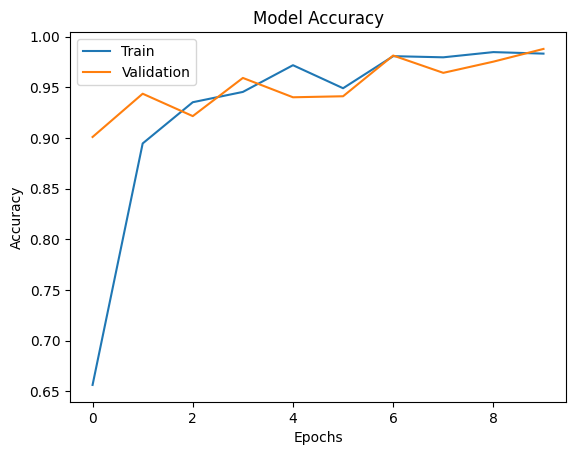

In [7]:
#save history
np.save('history.npy', history.history)
print('History saved')
# plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

# save plot
plt.savefig('accuracy.png')
# compare predictions with actual labels
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)
actual = np.concatenate([y for x, y in test_data], axis=0)

# calculate accuracy
accuracy = np.mean(predictions == actual)
print(f'Accuracy: {accuracy}')

## Comparative Analysis

Comparing just the accuracy of the baseline and the model.
